In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import cv2
from tqdm.auto import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from tensorflow.keras import layers, Model, Input,applications
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, Activation,Add
from tensorflow.keras.applications import MobileNet as KerasMobileNet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB0

import warnings
warnings.filterwarnings("ignore")  

class PreProcessing:
    def __init__(self,base_path = "processed",img_size=(224,224)):
        self.base_path = base_path
        self.img_size = img_size

        self.image_folder = os.path.join(base_path,"images") 
        self.mask_folder = os.path.join(base_path,"masks")
        self.train_img_folder = os.path.join(base_path,"train/images")
        self.train_mask_folder = os.path.join(base_path,"train/masks")
        self.val_img_folder = os.path.join(base_path,"val/images")
        self.val_mask_folder = os.path.join(base_path,"val/masks")
        self.test_img_folder = os.path.join(base_path,"test/images")
        self.test_mask_folder = os.path.join(base_path,"test/masks")

    def make_dir(self):
        folders = [self.image_folder,self.mask_folder ,self.train_img_folder,self.train_mask_folder,self.val_img_folder,self.val_mask_folder ,self.test_img_folder,self.test_mask_folder ]
        for folder in folders:
            os.makedirs(folder,exist_ok=True)
    
    def split_dataset(self,test_size=0.1,val_size=0.1):
        images = sorted([f for f in os.listdir(self.image_folder) if f.lower().endswith((".jpg", ".png"))])
        masks  = sorted([f for f in os.listdir(self.mask_folder) if f.lower().endswith((".jpg", ".png"))])

        train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=test_size, random_state=42)
        train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=val_size, random_state=42)

        self.train_images, self.val_images, self.test_images = train_images, val_images, test_images
        self.train_masks, self.val_masks, self.test_masks = train_masks, val_masks, test_masks

        print(f"Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

    def generate_lane_mask(self,img_folder,mask_folder,img_files,mask_files):
        images = []
        masks = []
        for img_file,mask_file in zip(img_files,mask_files):
            img_path = os.path.join(img_folder,img_file)
            mask_path = os.path.join(mask_folder,mask_file)
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
            if img is None or mask is None:
                continue

            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,self.img_size) / 255.0
            mask = cv2.resize(mask,self.img_size) / 255.0
            mask = np.expand_dims(mask, -1)

            images.append(img)
            masks.append(mask)
        return np.array(images, np.float32), np.array(masks, np.float32)
    
    def load_data(self):
        train_X, train_Y = self.generate_lane_mask(self.train_img_folder, self.train_mask_folder, self.train_images, self.train_masks)
        val_X, val_Y     = self.generate_lane_mask(self.val_img_folder, self.val_mask_folder, self.val_images, self.val_masks)
        test_X, test_Y   = self.generate_lane_mask(self.test_img_folder, self.test_mask_folder, self.test_images, self.test_masks)
        print("Data loaded:", train_X.shape, val_X.shape, test_X.shape)
        return train_X, train_Y, val_X, val_Y, test_X, test_Y




class PathConnectivity:
    def __init__(self,connectivity=8):
        self.connectivity = connectivity
        self.kernel = np.ones((3,3),np.uint8)
    
    def dilate_mask(self,mask):
        return cv2.dilate(mask,self.kernel,iterations=1)
    
    def iou(self,mask_pred,mask_gt):
        mask_pred_dilated = self.dilate_mask(mask_pred.astype(np.uint8))
        mask_gt_dilated = self.dilate_mask(mask_gt.astype(np.uint8))

        intersection = np.logical_and(mask_pred_dilated, mask_gt_dilated).sum()
        union = np.logical_or(mask_pred_dilated, mask_gt_dilated).sum()
        if union == 0:
            return 1.0 
        return intersection / union


class Visulation:
    def __init__(self):
        pass

    def show_image_mask(self, image, mask_gt, mask_pred=None, iou_score=None):
        """
        Görselleştirme fonksiyonu
        image      : RGB image (H,W,3)
        mask_gt    : Ground truth mask (H,W)
        mask_pred  : Tahmin maskesi (H,W) - optional
        iou_score  : IoU değeri - optional
        """
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask_gt[:,:,0] if mask_gt.ndim==3 else mask_gt, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        if mask_pred is not None:
            plt.subplot(1,3,3)
            plt.imshow(mask_pred[:,:,0] if mask_pred.ndim==3 else mask_pred, cmap='gray')
            title = "Prediction"
            if iou_score is not None:
                title += f" | IoU: {iou_score:.4f}"
            plt.title(title)
            plt.axis("off")

        plt.show()

    def overlay_masks(self, image, mask_gt, mask_pred, alpha=0.5):
        overlay = image.copy()
        mask_gt_colored = np.zeros_like(image)
        mask_gt_colored[:,:,0] = mask_gt[:,:,0]*255  
        mask_pred_colored = np.zeros_like(image)
        mask_pred_colored[:,:,1] = mask_pred[:,:,0]*255  

        combined = cv2.addWeighted(overlay,1.0,mask_gt_colored,alpha,0)
        combined = cv2.addWeighted(combined,1.0,mask_pred_colored,alpha,0)

        plt.figure(figsize=(6,6))
        plt.imshow(combined.astype(np.uint8))
        plt.title("Overlay: Red=GT, Green=Prediction")
        plt.axis("off")
        plt.show()


class VGG19Seg(Model):
    def __init__(self, input_shape=(224,224,3)):
        super(VGG19Seg, self).__init__()
        # Encoder
        self.conv1_1 = layers.Conv2D(64, (3,3), padding="same", activation="relu")
        self.conv1_2 = layers.Conv2D(64, (3,3), padding="same", activation="relu")
        self.pool1 = layers.MaxPooling2D((2,2))

        self.conv2_1 = layers.Conv2D(128, (3,3), padding="same", activation="relu")
        self.conv2_2 = layers.Conv2D(128, (3,3), padding="same", activation="relu")
        self.pool2 = layers.MaxPooling2D((2,2))

        self.conv3_1 = layers.Conv2D(256, (3,3), padding="same", activation="relu")
        self.conv3_2 = layers.Conv2D(256, (3,3), padding="same", activation="relu")
        self.conv3_3 = layers.Conv2D(256, (3,3), padding="same", activation="relu")
        self.conv3_4 = layers.Conv2D(256, (3,3), padding="same", activation="relu")
        self.pool3 = layers.MaxPooling2D((2,2))

        self.conv4_1 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.conv4_2 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.conv4_3 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.conv4_4 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.pool4 = layers.MaxPooling2D((2,2))

        self.conv5_1 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.conv5_2 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.conv5_3 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.conv5_4 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.pool5 = layers.MaxPooling2D((2,2))

        # Decoder
        self.up1 = layers.UpSampling2D((2,2))
        self.dec1 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.up2 = layers.UpSampling2D((2,2))
        self.dec2 = layers.Conv2D(512, (3,3), padding="same", activation="relu")
        self.up3 = layers.UpSampling2D((2,2))
        self.dec3 = layers.Conv2D(256, (3,3), padding="same", activation="relu")
        self.up4 = layers.UpSampling2D((2,2))
        self.dec4 = layers.Conv2D(128, (3,3), padding="same", activation="relu")
        self.up5 = layers.UpSampling2D((2,2))
        self.dec5 = layers.Conv2D(64, (3,3), padding="same", activation="relu")

        self.final = layers.Conv2D(1, (1,1), activation="sigmoid")

    def call(self, inputs):
        # Encoder
        x1 = self.conv1_1(inputs)
        x1 = self.conv1_2(x1)
        p1 = self.pool1(x1)

        x2 = self.conv2_1(p1)
        x2 = self.conv2_2(x2)
        p2 = self.pool2(x2)

        x3 = self.conv3_1(p2)
        x3 = self.conv3_2(x3)
        x3 = self.conv3_3(x3)
        x3 = self.conv3_4(x3)
        p3 = self.pool3(x3)

        x4 = self.conv4_1(p3)
        x4 = self.conv4_2(x4)
        x4 = self.conv4_3(x4)
        x4 = self.conv4_4(x4)
        p4 = self.pool4(x4)

        x5 = self.conv5_1(p4)
        x5 = self.conv5_2(x5)
        x5 = self.conv5_3(x5)
        x5 = self.conv5_4(x5)
        p5 = self.pool5(x5)

        # Decoder with skip conections(Most important part)
        u1 = self.up1(p5)
        u1 = layers.Concatenate()([u1, x5])
        u1 = self.dec1(u1)

        u2 = self.up2(u1)
        u2 = layers.Concatenate()([u2, x4])
        u2 = self.dec2(u2)

        u3 = self.up3(u2)
        u3 = layers.Concatenate()([u3, x3])
        u3 = self.dec3(u3)

        u4 = self.up4(u3)
        u4 = layers.Concatenate()([u4, x2])
        u4 = self.dec4(u4)

        u5 = self.up5(u4)
        u5 = layers.Concatenate()([u5, x1])
        u5 = self.dec5(u5)

        return self.final(u5)

class ResNet50Seg(Model):
    def __init__(self, input_shape=(224,224,3)):
        super(ResNet50Seg, self).__init__()
        # Pretrained ResNet50 backbone
        self.backbone = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
        self.backbone.trainable = True  # If you want, you can set it to False and train only the decoder

        # Decoder
        self.up1 = layers.UpSampling2D((2,2)); self.dec1 = layers.Conv2D(256, (3,3), padding="same", activation="relu")
        self.up2 = layers.UpSampling2D((2,2)); self.dec2 = layers.Conv2D(128, (3,3), padding="same", activation="relu")
        self.up3 = layers.UpSampling2D((2,2)); self.dec3 = layers.Conv2D(64, (3,3), padding="same", activation="relu")
        self.up4 = layers.UpSampling2D((2,2)); self.dec4 = layers.Conv2D(32, (3,3), padding="same", activation="relu")
        self.up5 = layers.UpSampling2D((2,2)); self.dec5 = layers.Conv2D(16, (3,3), padding="same", activation="relu")
        self.final = layers.Conv2D(1, (1,1), activation="sigmoid")

    def call(self, inputs):
        x = self.backbone(inputs)
        x = self.up1(x); x = self.dec1(x)
        x = self.up2(x); x = self.dec2(x)
        x = self.up3(x); x = self.dec3(x)
        x = self.up4(x); x = self.dec4(x)
        x = self.up5(x); x = self.dec5(x)
        return self.final(x)


#Models
#--------------------

# MobileNetSeg

class MobileNetSeg(Model):
    def __init__(self, input_shape=(224,224,3)):
        super(MobileNetSeg, self).__init__()
        self.backbone = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
        self.up1 = UpSampling2D((2,2))
        self.dec1 = Conv2D(256, (3,3), padding="same", activation="relu")
        self.up2 = UpSampling2D((2,2))
        self.dec2 = Conv2D(128, (3,3), padding="same", activation="relu")
        self.up3 = UpSampling2D((2,2))
        self.dec3 = Conv2D(64, (3,3), padding="same", activation="relu")
        self.up4 = UpSampling2D((2,2))
        self.dec4 = Conv2D(32, (3,3), padding="same", activation="relu")
        self.up5 = UpSampling2D((2,2))
        self.dec5 = Conv2D(16, (3,3), padding="same", activation="relu")
        self.final = Conv2D(1, (1,1), activation="sigmoid")

    def call(self, inputs):
        x = self.backbone(inputs)
        x = self.up1(x); x = self.dec1(x)
        x = self.up2(x); x = self.dec2(x)
        x = self.up3(x); x = self.dec3(x)
        x = self.up4(x); x = self.dec4(x)
        x = self.up5(x); x = self.dec5(x)
        return self.final(x)


# EfficientNetSeg
class EfficientNetSeg(Model):
    def __init__(self, input_shape=(224,224,3)):
        super(EfficientNetSeg, self).__init__()
        self.backbone = tf.keras.applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
        
        # Decoder
        self.up1 = UpSampling2D((2,2)); self.dec1 = Conv2D(256, (3,3), padding="same", activation="relu")
        self.up2 = UpSampling2D((2,2)); self.dec2 = Conv2D(128, (3,3), padding="same", activation="relu")
        self.up3 = UpSampling2D((2,2)); self.dec3 = Conv2D(64, (3,3), padding="same", activation="relu")
        self.up4 = UpSampling2D((2,2)); self.dec4 = Conv2D(32, (3,3), padding="same", activation="relu")
        self.up5 = UpSampling2D((2,2)); self.dec5 = Conv2D(16, (3,3), padding="same", activation="relu")
        self.final = Conv2D(1, (1,1), activation="sigmoid")

    def call(self, inputs):
        x = self.backbone(inputs)
        x = self.up1(x); x = self.dec1(x)
        x = self.up2(x); x = self.dec2(x)
        x = self.up3(x); x = self.dec3(x)
        x = self.up4(x); x = self.dec4(x)
        x = self.up5(x); x = self.dec5(x)
        return self.final(x)


# DenseNetSeg
class DenseNetSeg(Model):
    def __init__(self, input_shape=(224,224,3)):
        super(DenseNetSeg, self).__init__()
        self.backbone = tf.keras.applications.DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet')
        
        # Decoder
        self.up1 = UpSampling2D((2,2)); self.dec1 = Conv2D(256, (3,3), padding="same", activation="relu")
        self.up2 = UpSampling2D((2,2)); self.dec2 = Conv2D(128, (3,3), padding="same", activation="relu")
        self.up3 = UpSampling2D((2,2)); self.dec3 = Conv2D(64, (3,3), padding="same", activation="relu")
        self.up4 = UpSampling2D((2,2)); self.dec4 = Conv2D(32, (3,3), padding="same", activation="relu")
        self.up5 = UpSampling2D((2,2)); self.dec5 = Conv2D(16, (3,3), padding="same", activation="relu")
        self.final = Conv2D(1, (1,1), activation="sigmoid")

    def call(self, inputs):
        x = self.backbone(inputs)
        x = self.up1(x); x = self.dec1(x)
        x = self.up2(x); x = self.dec2(x)
        x = self.up3(x); x = self.dec3(x)
        x = self.up4(x); x = self.dec4(x)
        x = self.up5(x); x = self.dec5(x)
        return self.final(x)

class Loss:
    @staticmethod
    def dice_loss(y_true, y_pred, smooth=1e-6):
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

    @staticmethod
    def weighted_bce_dice_loss(y_true, y_pred, weight=5):
        bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
        dice = Loss.dice_loss(y_true, y_pred)
        return bce + weight * dice

prep = PreProcessing(base_path="processed", img_size=(224,224))
prep.make_dir()
prep.split_dataset(test_size=0.1, val_size=0.1)
train_X, train_Y, val_X, val_Y, test_X, test_Y = prep.load_data()  

train_X = train_X.astype("float32")
val_X   = val_X.astype("float32")
test_X  = test_X.astype("float32")
train_Y = train_Y.astype("float32")
val_Y   = val_Y.astype("float32")
test_Y  = test_Y.astype("float32")

if train_Y.max() > 1.0:
    train_Y /= 255.0
    val_Y   /= 255.0
    test_Y  /= 255.0


models_subclass = {
    "vgg19seg_model": VGG19Seg,
    "resnet50_model": ResNet50Seg,
    "mobilenet_model": MobileNetSeg,
    "efficientnet_model": EfficientNetSeg,
    "densenet_model": DenseNetSeg
}

def train_and_save_model(model_class, save_name, train_X, train_Y, val_X, val_Y):
    print(f"\Training {save_name}...")

    model = model_class(input_shape=(224,224,3))
    inputs = tf.keras.Input(shape=(224,224,3))
    _ = model(inputs)  # Build and weight init

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(1e-4),
        loss=Loss.weighted_bce_dice_loss,
        metrics=["accuracy"]
    )

    history = model.fit(
        train_X, train_Y,
        validation_data=(val_X, val_Y),
        batch_size=4,
        epochs=10,
        verbose=1
    )

    model.save(save_name, save_format="tf")
    print(f"✅ {save_name} başarıyla kaydedildi!")

    return model, history

# Training snd save for all models
for save_name, cls in models_subclass.items():
    try:
        model, history = train_and_save_model(cls, save_name, train_X, train_Y, val_X, val_Y)
    except Exception as e:
        print(f"{save_name} there is a problem at training:\n{e}")


print("Test shape:", test_X.shape, test_Y.shape)


✅ Train: 2936, Val: 327, Test: 363
Data loaded: (2911, 224, 224, 3) (82, 224, 224, 3) (80, 224, 224, 3)

🚀 Training vgg19seg_model...
Epoch 1/10
728/728 [==============================] - 414s 552ms/step - loss: 2.7842 - accuracy: 0.9457 - val_loss: 1.9126 - val_accuracy: 0.9577
Epoch 2/10
728/728 [==============================] - 351s 483ms/step - loss: 1.7900 - accuracy: 0.9578 - val_loss: 1.7709 - val_accuracy: 0.9590
Epoch 3/10
728/728 [==============================] - 354s 486ms/step - loss: 1.6476 - accuracy: 0.9593 - val_loss: 1.6297 - val_accuracy: 0.9594
Epoch 4/10
728/728 [==============================] - 346s 475ms/step - loss: 1.5823 - accuracy: 0.9598 - val_loss: 1.5822 - val_accuracy: 0.9603
Epoch 5/10
728/728 [==============================] - 346s 476ms/step - loss: 1.5199 - accuracy: 0.9604 - val_loss: 1.5356 - val_accuracy: 0.9604
Epoch 6/10
728/728 [==============================] - 344s 473ms/step - loss: 1.4753 - accuracy: 0.9609 - val_loss: 1.6102 - val_accurac

INFO:tensorflow:Assets written to: vgg19seg_model/assets


✅ vgg19seg_model başarıyla kaydedildi!

🚀 Training resnet50_model...
❌ resnet50_model eğitiminde hata oluştu:
ResNet50Seg.__init__() got an unexpected keyword argument 'include_top'

🚀 Training mobilenet_model...
Epoch 1/10
728/728 [==============================] - 86s 108ms/step - loss: 3.8604 - accuracy: 0.9278 - val_loss: 3.6726 - val_accuracy: 0.9299
Epoch 2/10
728/728 [==============================] - 71s 98ms/step - loss: 3.3444 - accuracy: 0.9351 - val_loss: 3.5865 - val_accuracy: 0.9400
Epoch 3/10
728/728 [==============================] - 72s 99ms/step - loss: 3.0216 - accuracy: 0.9393 - val_loss: 3.0903 - val_accuracy: 0.9444
Epoch 4/10
728/728 [==============================] - 73s 101ms/step - loss: 2.8547 - accuracy: 0.9429 - val_loss: 3.0878 - val_accuracy: 0.9435
Epoch 5/10
728/728 [==============================] - 74s 102ms/step - loss: 2.7315 - accuracy: 0.9451 - val_loss: 2.8536 - val_accuracy: 0.9468
Epoch 6/10
728/728 [==============================] - 73s 101ms/

INFO:tensorflow:Assets written to: mobilenet_model/assets


✅ mobilenet_model başarıyla kaydedildi!

🚀 Training efficientnet_model...
31790344/31790344 [==============================] - 2s 0us/step
Epoch 1/10
728/728 [==============================] - 193s 233ms/step - loss: 3.7774 - accuracy: 0.9301 - val_loss: 4.4935 - val_accuracy: 0.9444
Epoch 2/10
728/728 [==============================] - 149s 205ms/step - loss: 3.1852 - accuracy: 0.9382 - val_loss: 3.9632 - val_accuracy: 0.9428
Epoch 3/10
728/728 [==============================] - 150s 206ms/step - loss: 2.9275 - accuracy: 0.9421 - val_loss: 5.0495 - val_accuracy: 0.9508
Epoch 4/10
728/728 [==============================] - 152s 209ms/step - loss: 2.7937 - accuracy: 0.9442 - val_loss: 4.7325 - val_accuracy: 0.9503
Epoch 5/10
728/728 [==============================] - 153s 209ms/step - loss: 2.6553 - accuracy: 0.9462 - val_loss: 5.0272 - val_accuracy: 0.9529
Epoch 6/10
728/728 [==============================] - 154s 211ms/step - loss: 2.5498 - accuracy: 0.9477 - val_loss: 5.1003 - val_ac

INFO:tensorflow:Assets written to: efficientnet_model/assets


✅ efficientnet_model başarıyla kaydedildi!

🚀 Training densenet_model...
Epoch 1/10
728/728 [==============================] - 203s 257ms/step - loss: 3.0993 - accuracy: 0.9382 - val_loss: 2.4898 - val_accuracy: 0.9499
Epoch 2/10
728/728 [==============================] - 172s 236ms/step - loss: 2.0950 - accuracy: 0.9534 - val_loss: 1.9289 - val_accuracy: 0.9569
Epoch 3/10
728/728 [==============================] - 172s 236ms/step - loss: 1.8078 - accuracy: 0.9571 - val_loss: 1.8323 - val_accuracy: 0.9583
Epoch 4/10
728/728 [==============================] - 178s 245ms/step - loss: 1.6437 - accuracy: 0.9591 - val_loss: 1.7528 - val_accuracy: 0.9581
Epoch 5/10
728/728 [==============================] - 180s 247ms/step - loss: 1.5195 - accuracy: 0.9604 - val_loss: 1.8512 - val_accuracy: 0.9577
Epoch 6/10
728/728 [==============================] - 172s 236ms/step - loss: 1.4446 - accuracy: 0.9612 - val_loss: 1.6472 - val_accuracy: 0.9601
Epoch 7/10
728/728 [==============================]

INFO:tensorflow:Assets written to: densenet_model/assets


✅ densenet_model başarıyla kaydedildi!
Test verileri shape: (80, 224, 224, 3) (80, 224, 224, 1)


✅ Model yüklendi: densenet_model
91/91 [==============================] - 59s 591ms/step

📊 Mean IoU (PathConnectivity, dilate ile): 0.6967


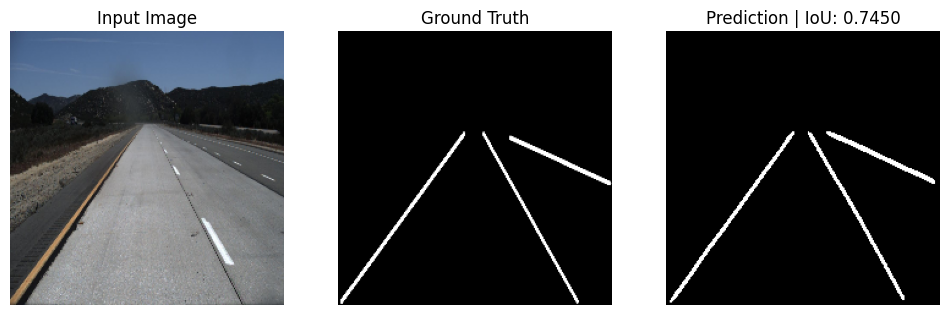

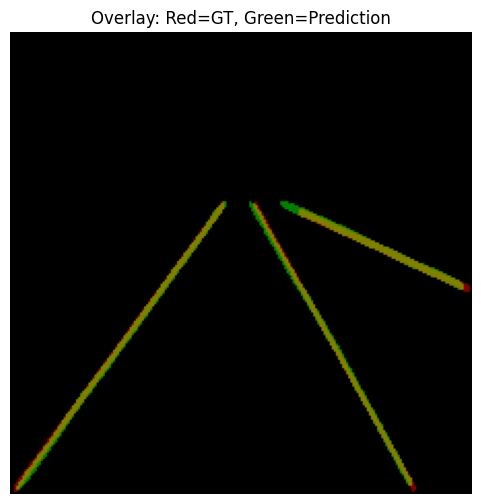

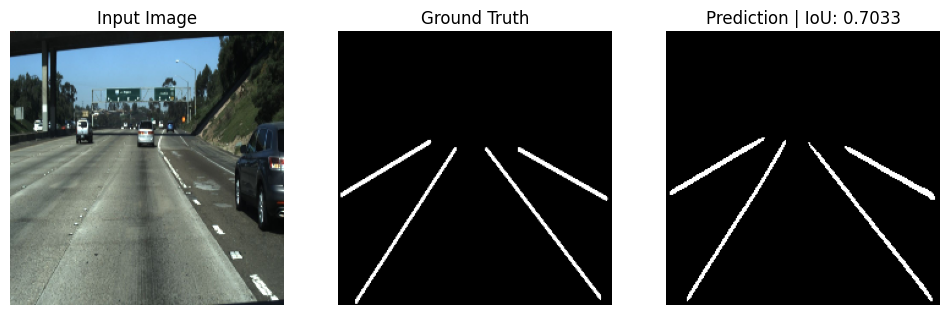

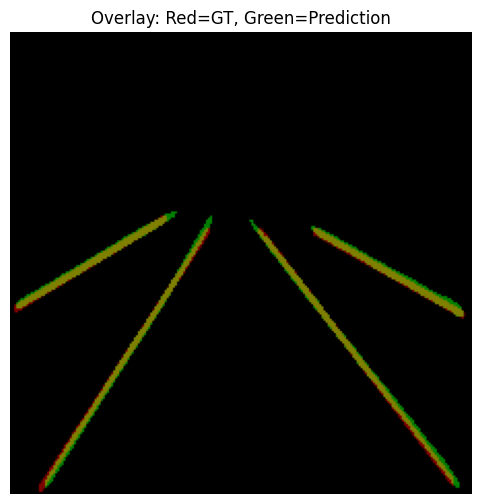

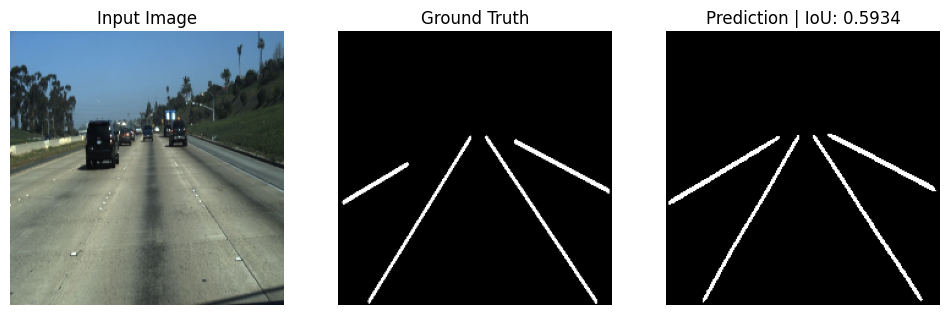

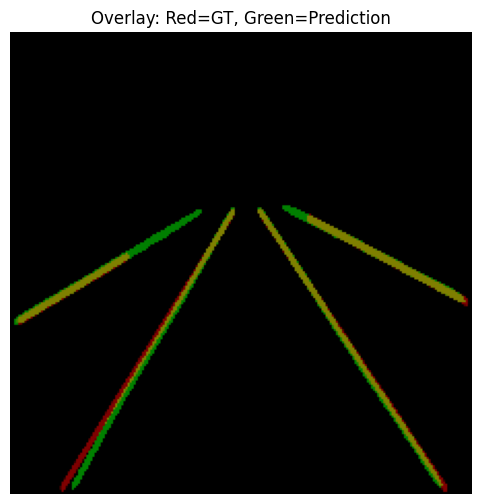

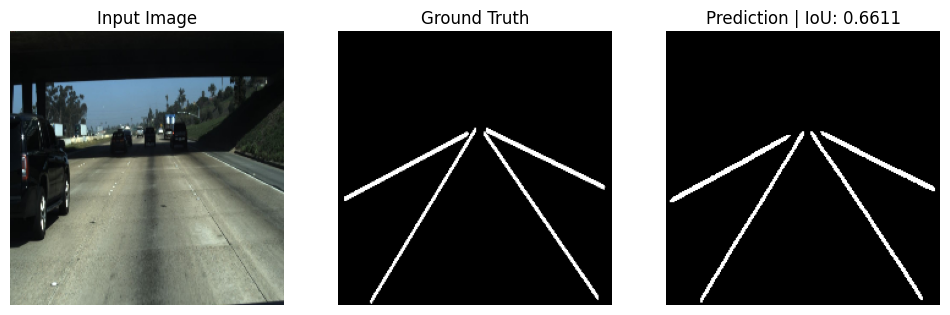

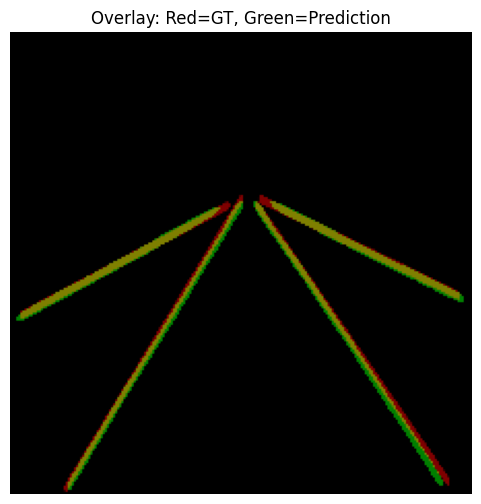

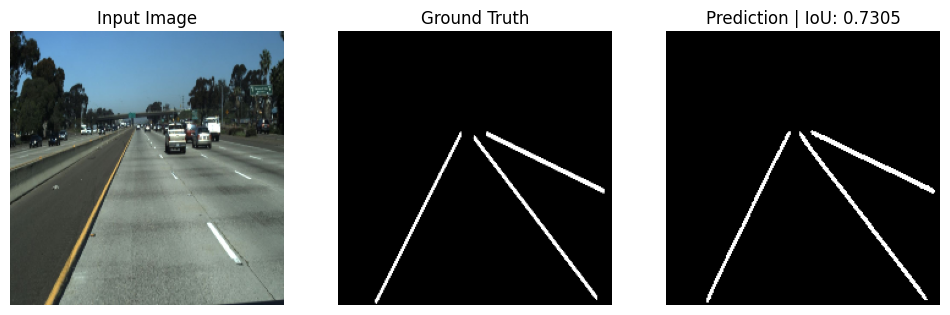

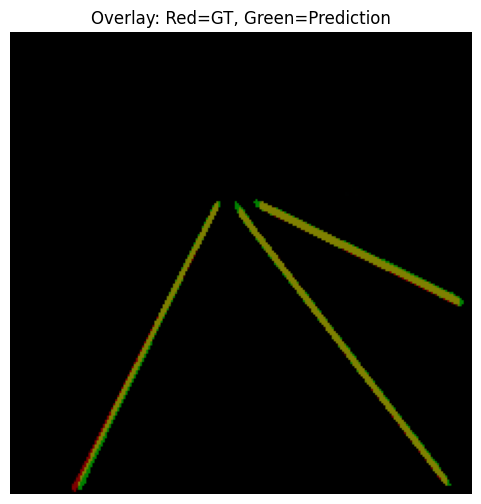

In [ ]:
model = tf.keras.models.load_model("resnet50_model", compile=False)
print("Model loaded:", "densenet_model")

preds_test = model.predict(train_X, verbose=1)
preds_test_bin = (preds_test > 0.5).astype(np.uint8)

pc = PathConnectivity(connectivity=8)

ious = []
for gt, pred in zip(train_Y, preds_test_bin):
    iou_score = pc.iou(pred, gt)
    ious.append(iou_score)

mean_iou = np.mean(ious)
print(f"\n📊 Mean IoU (PathConnectivity, dilate ile): {mean_iou:.4f}")

vis = Visulation()
n_samples = 5
indices = np.random.choice(len(train_X), n_samples, replace=False)

for idx in indices:
    vis.show_image_mask(
        train_X[idx],
        train_Y[idx],
        preds_test_bin[idx],
        iou_score=pc.iou(preds_test_bin[idx], train_Y[idx])
    )

    vis.overlay_masks(
        train_X[idx],
        train_Y[idx],
        preds_test_bin[idx]
    )


In [ ]:
# RESNET50 Segmentation
#I wrote the open version of resnet50 but I couldn't use it because it was running very slow
#If you want you can paste this resnet50 code above
class RESNET50(Model):
    def __init__(self, input_shape=(224,224,3)):
        super(RESNET50, self).__init__()
        self.conv1 = Conv2D(64, (7,7), strides=(2,2), padding="same")
        self.bn1 = BatchNormalization()
        self.relu1 = Activation("relu")
        self.pool1 = MaxPooling2D((3,3), strides=(2,2), padding="same")

        # Conv and Identity block 64
        self.id1_conv1 = Conv2D(64, (3,3), padding="same")
        self.id1_bn1 = BatchNormalization()
        self.id1_conv2 = Conv2D(64, (3,3), padding="same")
        self.id1_bn2 = BatchNormalization()
        
        self.id2_conv1 = Conv2D(64, (3,3), padding="same")
        self.id2_bn1 = BatchNormalization()
        self.id2_conv2 = Conv2D(64, (3,3), padding="same")
        self.id2_bn2 = BatchNormalization()
        
        # Conv block 128
        self.cb128_shortcut = Conv2D(128, (1,1), strides=(2,2), padding="same")
        self.cb128_bn_shortcut = BatchNormalization()
        self.cb128_conv1 = Conv2D(128, (3,3), strides=(2,2), padding="same")
        self.cb128_bn1 = BatchNormalization()
        self.cb128_conv2 = Conv2D(128, (3,3), padding="same")
        self.cb128_bn2 = BatchNormalization()
        
        # Identity block 128
        self.id3_conv1 = Conv2D(128, (3,3), padding="same")
        self.id3_bn1 = BatchNormalization()
        self.id3_conv2 = Conv2D(128, (3,3), padding="same")
        self.id3_bn2 = BatchNormalization()
        
        # Conv block 256
        self.cb256_shortcut = Conv2D(256, (1,1), strides=(2,2), padding="same")
        self.cb256_bn_shortcut = BatchNormalization()
        self.cb256_conv1 = Conv2D(256, (3,3), strides=(2,2), padding="same")
        self.cb256_bn1 = BatchNormalization()
        self.cb256_conv2 = Conv2D(256, (3,3), padding="same")
        self.cb256_bn2 = BatchNormalization()
        
        # Identity block 256
        self.id4_conv1 = Conv2D(256, (3,3), padding="same")
        self.id4_bn1 = BatchNormalization()
        self.id4_conv2 = Conv2D(256, (3,3), padding="same")
        self.id4_bn2 = BatchNormalization()
        
        # Conv block 512
        self.cb512_shortcut = Conv2D(512, (1,1), strides=(2,2), padding="same")
        self.cb512_bn_shortcut = BatchNormalization()
        self.cb512_conv1 = Conv2D(512, (3,3), strides=(2,2), padding="same")
        self.cb512_bn1 = BatchNormalization()
        self.cb512_conv2 = Conv2D(512, (3,3), padding="same")
        self.cb512_bn2 = BatchNormalization()
        
        # Identity block 512
        self.id5_conv1 = Conv2D(512, (3,3), padding="same")
        self.id5_bn1 = BatchNormalization()
        self.id5_conv2 = Conv2D(512, (3,3), padding="same")
        self.id5_bn2 = BatchNormalization()

        # Decoder layer
        self.dec1_conv1 = Conv2D(256, (3,3), padding="same")
        self.dec1_bn1 = BatchNormalization()
        self.dec1_conv2 = Conv2D(256, (3,3), padding="same")
        self.dec1_bn2 = BatchNormalization()
        
        self.dec2_conv1 = Conv2D(128, (3,3), padding="same")
        self.dec2_bn1 = BatchNormalization()
        self.dec2_conv2 = Conv2D(128, (3,3), padding="same")
        self.dec2_bn2 = BatchNormalization()
        
        self.dec3_conv1 = Conv2D(64, (3,3), padding="same")
        self.dec3_bn1 = BatchNormalization()
        self.dec3_conv2 = Conv2D(64, (3,3), padding="same")
        self.dec3_bn2 = BatchNormalization()
        
        self.dec4_conv1 = Conv2D(32, (3,3), padding="same")
        self.dec4_bn1 = BatchNormalization()
        self.dec4_conv2 = Conv2D(32, (3,3), padding="same")
        self.dec4_bn2 = BatchNormalization()
        
        self.dec5_conv1 = Conv2D(16, (3,3), padding="same")
        self.dec5_bn1 = BatchNormalization()
        self.dec5_conv2 = Conv2D(16, (3,3), padding="same")
        self.dec5_bn2 = BatchNormalization()

        # UpSampling and final
        self.up1 = UpSampling2D((2,2))
        self.up2 = UpSampling2D((2,2))
        self.up3 = UpSampling2D((2,2))
        self.up4 = UpSampling2D((2,2))
        self.up5 = UpSampling2D((2,2))
        self.final_conv = Conv2D(1, (1,1), activation="sigmoid")

    def call(self, inputs):
        # Initial conv
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Identity block 1 (64)
        shortcut = x
        x = self.id1_conv1(x)
        x = self.id1_bn1(x)
        x = Activation("relu")(x)
        x = self.id1_conv2(x)
        x = self.id1_bn2(x)
        x = Add()([x, shortcut])
        x = Activation("relu")(x)
        
        # Identity block 2 (64)
        shortcut = x
        x = self.id2_conv1(x)
        x = self.id2_bn1(x)
        x = Activation("relu")(x)
        x = self.id2_conv2(x)
        x = self.id2_bn2(x)
        x = Add()([x, shortcut])
        x = Activation("relu")(x)
        
        # Conv block 128
        shortcut = self.cb128_shortcut(x)
        shortcut = self.cb128_bn_shortcut(shortcut)
        x = self.cb128_conv1(x)
        x = self.cb128_bn1(x)
        x = Activation("relu")(x)
        x = self.cb128_conv2(x)
        x = self.cb128_bn2(x)
        x = Add()([x, shortcut])
        x = Activation("relu")(x)
        
        # Identity block 3 (128)
        shortcut = x
        x = self.id3_conv1(x)
        x = self.id3_bn1(x)
        x = Activation("relu")(x)
        x = self.id3_conv2(x)
        x = self.id3_bn2(x)
        x = Add()([x, shortcut])
        x = Activation("relu")(x)
        
        # Conv block 256
        shortcut = self.cb256_shortcut(x)
        shortcut = self.cb256_bn_shortcut(shortcut)
        x = self.cb256_conv1(x)
        x = self.cb256_bn1(x)
        x = Activation("relu")(x)
        x = self.cb256_conv2(x)
        x = self.cb256_bn2(x)
        x = Add()([x, shortcut])
        x = Activation("relu")(x)
        
        # Identity block 4 (256)
        shortcut = x
        x = self.id4_conv1(x)
        x = self.id4_bn1(x)
        x = Activation("relu")(x)
        x = self.id4_conv2(x)
        x = self.id4_bn2(x)
        x = Add()([x, shortcut])
        x = Activation("relu")(x)
        
        # Conv block 512
        shortcut = self.cb512_shortcut(x)
        shortcut = self.cb512_bn_shortcut(shortcut)
        x = self.cb512_conv1(x)
        x = self.cb512_bn1(x)
        x = Activation("relu")(x)
        x = self.cb512_conv2(x)
        x = self.cb512_bn2(x)
        x = Add()([x, shortcut])
        x = Activation("relu")(x)
        
        # Identity block 5 (512)
        shortcut = x
        x = self.id5_conv1(x)
        x = self.id5_bn1(x)
        x = Activation("relu")(x)
        x = self.id5_conv2(x)
        x = self.id5_bn2(x)
        x = Add()([x, shortcut])
        x = Activation("relu")(x)

        # Decoder
        x = self.up1(x)
        x = self.dec1_conv1(x)
        x = self.dec1_bn1(x)
        x = Activation("relu")(x)
        x = self.dec1_conv2(x)
        x = self.dec1_bn2(x)
        x = Activation("relu")(x)
        
        x = self.up2(x)
        x = self.dec2_conv1(x)
        x = self.dec2_bn1(x)
        x = Activation("relu")(x)
        x = self.dec2_conv2(x)
        x = self.dec2_bn2(x)
        x = Activation("relu")(x)
        
        x = self.up3(x)
        x = self.dec3_conv1(x)
        x = self.dec3_bn1(x)
        x = Activation("relu")(x)
        x = self.dec3_conv2(x)
        x = self.dec3_bn2(x)
        x = Activation("relu")(x)
        
        x = self.up4(x)
        x = self.dec4_conv1(x)
        x = self.dec4_bn1(x)
        x = Activation("relu")(x)
        x = self.dec4_conv2(x)
        x = self.dec4_bn2(x)
        x = Activation("relu")(x)
        
        x = self.up5(x)
        x = self.dec5_conv1(x)
        x = self.dec5_bn1(x)
        x = Activation("relu")(x)
        x = self.dec5_conv2(x)
        x = self.dec5_bn2(x)
        x = Activation("relu")(x)

        return self.final_conv(x)
